In [157]:
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

In [158]:
df = pd.read_excel('result.xlsx')
df

Unnamed: 0  ...                                          orig_body
0              0  ...                                  не прошли платежи
1              1  ...                                      нету кеш-бэк.
2              2  ...  доброго времени суток, совершил сегодня платеж...
3              3  ...            не работает приложение в другом регионе
4              4  ...  добрый день!\n\nтелефон: samsung galaxy s9\nос...
...          ...  ...                                                ...
2173        2173  ...          как использовать сертификаты лояльности ?
2174        2174  ...            оплата за еркц поступила не на тот счет
2175        2175  ...  как оплатить горячее питание горторг сертифика...
2176        2176  ...  не ясны некоторые поля при оплате счета по qr-...
2177        2177  ...  здравствуйте! не пойму, как удалить счет, на к...

[2178 rows x 6 columns]

In [159]:
col = ['body', 'class']
df = df[col] 
df = df[pd.notnull(df['class'])]
df['class_id'] = df['class'].factorize()[0]
category_id_df = df[['class', 'class_id']].drop_duplicates().sort_values('class_id')

category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['class_id', 'class']].values)

In [160]:
tfidf = TfidfVectorizer(sublinear_tf = True, min_df = 5, norm = '', encoding = 'utf-8', ngram_range = (1,2))
features = tfidf.fit_transform(df.body.values.astype('U'))

In [161]:
# Логистическая регрессия:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from random import randrange
import random

In [162]:
random.seed(randrange(100))
Name = []
AverageAccuracy = []
MaxAccuracy = []
MinAccuracy = []

In [166]:
#RandomSearch

from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV

#задаем параметрам диапазоны значений, которые нужно испытать:
tol = [float('{:.1f}'.format(x)) for x in np.linspace(start=0.1, stop=1, num=10)]
C = [float('{:.1f}'.format(x)) for x in np.linspace(start=0.1, stop=1, num=10)]
intercept_scaling = [float('{:.1f}'.format(x)) for x in np.linspace(start=0.1, stop=1, num=10)]
fit_intercept = [True, False]

mass = []

X_train, X_test, y_train, y_test = train_test_split(features, df['class_id'], random_state = randrange(100))

clf = LinearSVC(penalty = 'l2', dual = True, multi_class = 'ovr', 
                  loss='squared_hinge',
                  class_weight='balanced', verbose=0, 
                  random_state = randrange(100), max_iter = 1000) 

params = {
    'C' : C,
    'tol' : tol,
    'intercept_scaling' : intercept_scaling,
    'fit_intercept' : fit_intercept
} #словарь с параметрами

rs = RandomizedSearchCV(estimator=clf, 
                        param_distributions=params, 
                        n_iter = 1000, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0) 

rs.fit(X_train.toarray(), y_train)
print(rs.best_params_)
print(rs.best_score_)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 2488 tasks      | elapsed:  1.4min


{'tol': 1.0, 'intercept_scaling': 0.1, 'fit_intercept': True, 'C': 0.1}
0.6264604695089044


[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.7min finished


In [167]:
#датафрейм с результатами работы алгоритма RandomizedSearchCV
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

param_tol param_intercept_scaling  ... mean_test_score rank_test_score
0         1                     0.1  ...        0.626460               1
1       0.9                     0.1  ...        0.625236               2
2         1                     0.6  ...        0.624012               3
3       0.7                     0.1  ...        0.623401               4
4       0.8                     0.2  ...        0.623400               5
5       0.5                     0.1  ...        0.622786               6
6       0.7                     0.2  ...        0.622786               6
7         1                     0.4  ...        0.622178               8
8       0.5                     0.2  ...        0.622176               9
9       0.5                     0.9  ...        0.622174              10

[10 rows x 6 columns]

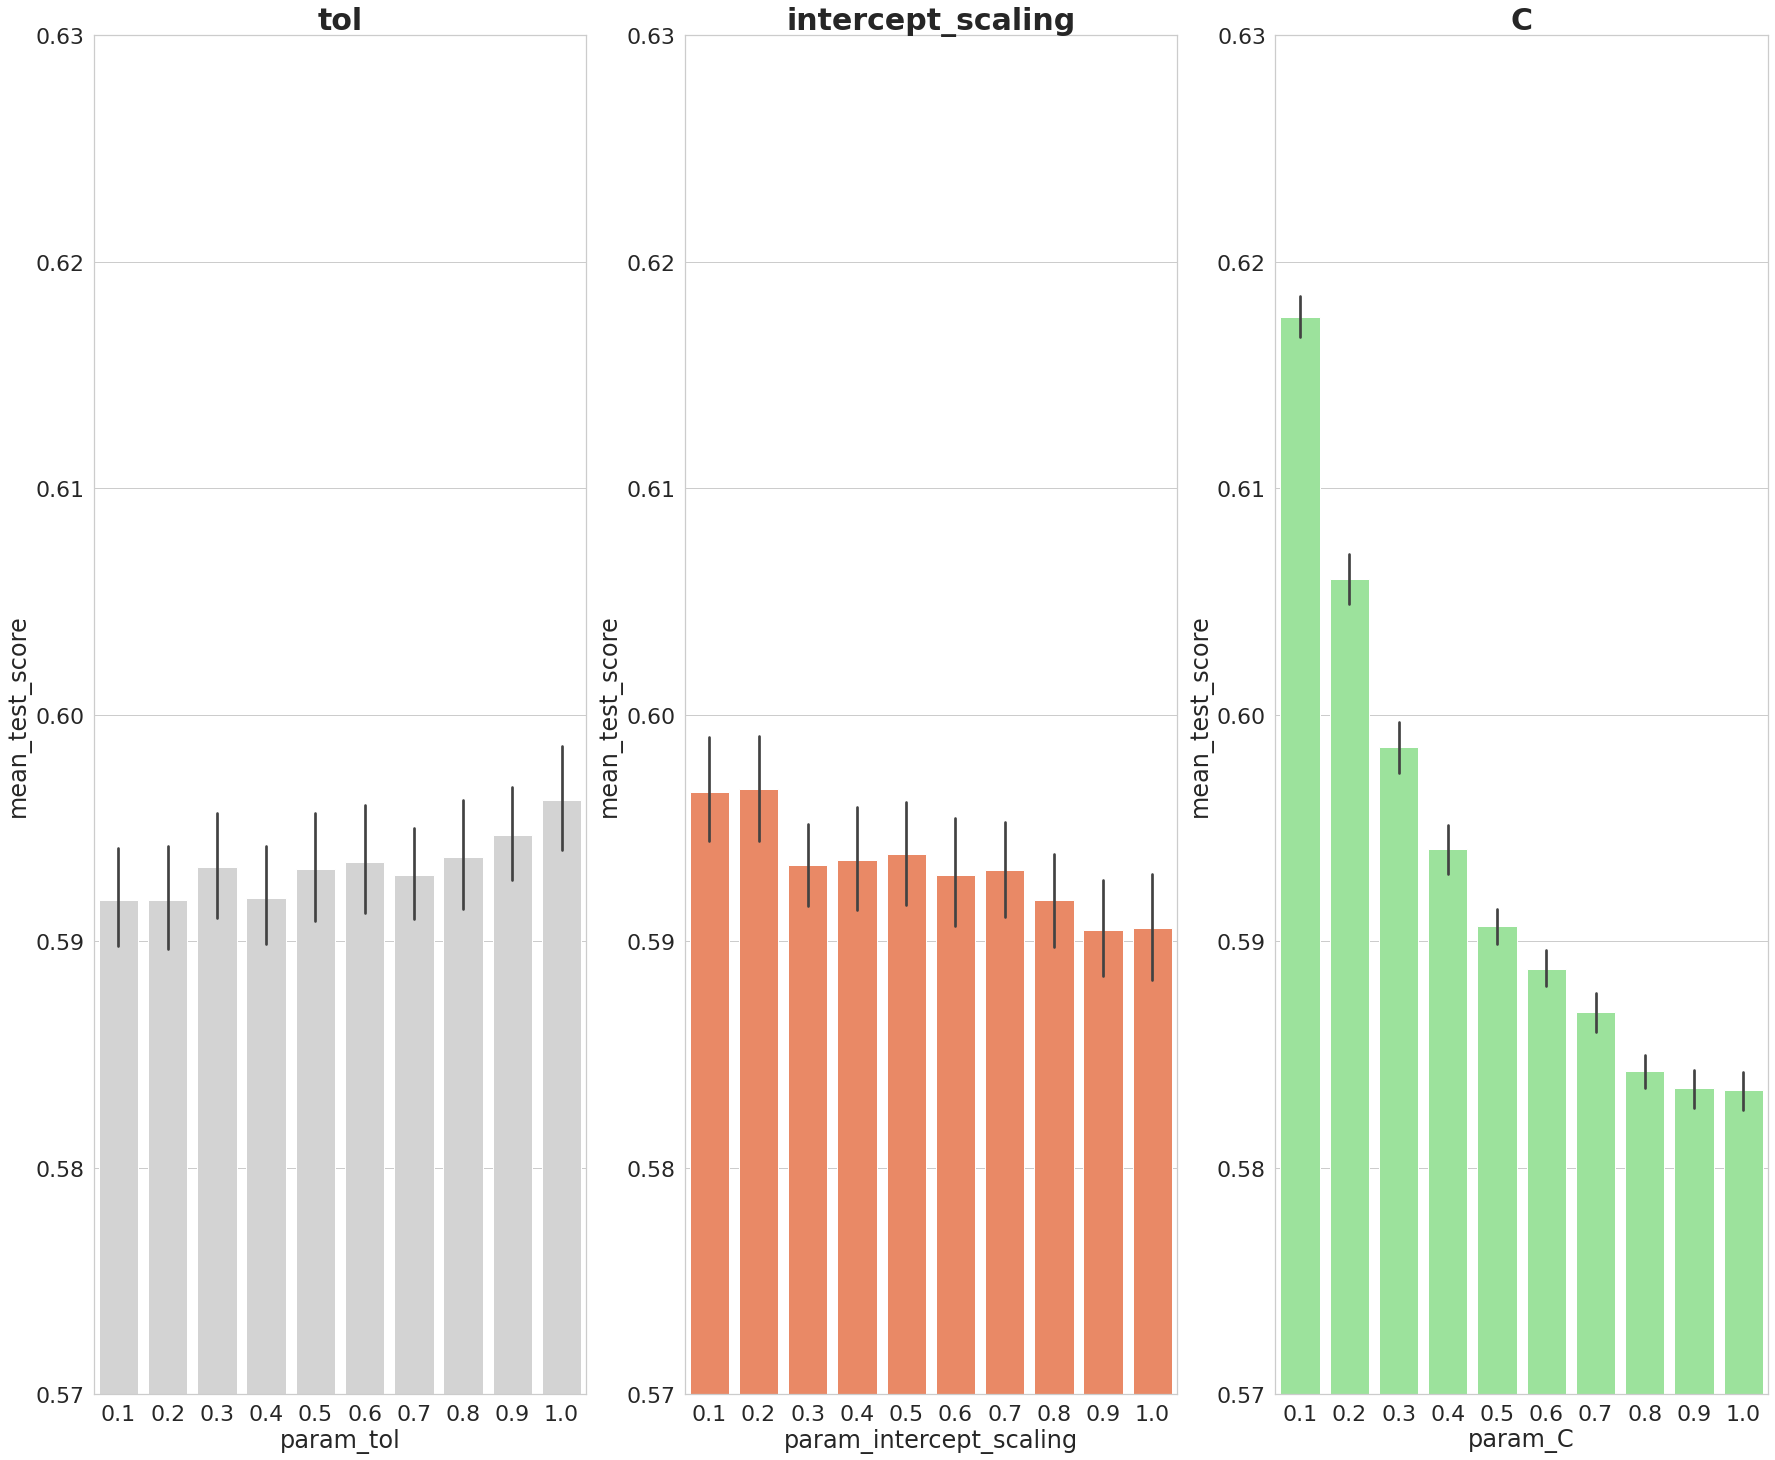

In [168]:
#построение диаграмм соотношения 
fig, axs = plt.subplots(ncols=3, nrows=1)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)

#tol
sns.barplot(x='param_tol', y='mean_test_score', data=rs_df, ax=axs[0], color='lightgrey')
axs[0].set_ylim([.57,.63])
axs[0].set_title(label = 'tol', size=30, weight='bold')

#intercept_scaling
sns.barplot(x='param_intercept_scaling', y='mean_test_score', data=rs_df, ax=axs[1], color='coral')
axs[1].set_ylim([.57,.63])
axs[1].set_title(label = 'intercept_scaling', size=30, weight='bold')

#C
sns.barplot(x='param_C', y='mean_test_score', data=rs_df, ax=axs[2], color='lightgreen')
axs[2].set_ylim([.57,.63])
axs[2].set_title(label = 'C', size=30, weight='bold')

plt.show()

In [169]:
# GridSearch
from sklearn.model_selection import GridSearchCV

best_tol = rs.best_params_['tol']
best_C = rs.best_params_['C']
best_is = rs.best_params_['intercept_scaling']

tol = []
C = []
intercept_scaling = []
k = -0.02
for i in range(8):
  tol.append(best_tol+k)
  C.append(best_C+k)
  intercept_scaling.append(best_is+k)
  k+=0.02


fit_intercept = ['False']
# dual = ['True'] 

gridParams = {
    'C' : C,
    'tol' : tol,
    'intercept_scaling' : intercept_scaling,
    'fit_intercept' : fit_intercept
}

gs = GridSearchCV(clf, gridParams, cv = 3, verbose = 1, n_jobs = -1)
gs.fit(X_train.toarray(), y_train)
best = gs.best_estimator_
gs.best_params_
gs.best_score_

Fitting 3 folds for each of 512 candidates, totalling 1536 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 716 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 1536 out of 1536 | elapsed:   38.2s finished


0.6307451879834503

In [170]:
mass = []
k = 100
s = 0.0
for i in range(k):
  X_train, X_test, y_train, y_test = train_test_split(features, df['class_id'], random_state = randrange(100))
  clf = LinearSVC(penalty = 'l2', loss = 'squared_hinge', dual = True, tol = gs.best_params_['tol'], C = gs.best_params_['C'], multi_class = 'ovr', 
                    fit_intercept = False, intercept_scaling= gs.best_params_['intercept_scaling'], class_weight='balanced', verbose=0, 
                    random_state = randrange(100), max_iter = 1000)
  clf = clf.fit(X_train.toarray(), y_train)
  cur_score = clf.score(X_test.toarray(), y_test)
  s += cur_score
  mass.append(cur_score)
print('Average:',s / k)
print('Min:', min(mass))
print('Max:', max(mass))

Average: 0.6541284403669725
Min: 0.6165137614678899
Max: 0.6990825688073394
